In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean , get_MOI, get_MOI_2D 
from invariance_functions import degree_of_freedom, get_GPR_model_2D, get_SHM_data_2D, get_double_pendulum_data, evaluate_model_future_2D, evaluate_model_grid_2D, SHM_dynamics1_2D, SHM_dynamics2_2D, get_GPR_model_GD_2D, double_pendulum_dynamics1, double_pendulum_dynamics2
from local_invariance_kernels import  get_polynomial_local_invariance_2D, get_SHM_local_invariance_2D, get_double_pendulum_local_invariance
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:

mean = ZeroMean(4) 

time_step = 0.01
training_time = 0.1
testing_time = 1

max_x = 60
max_v = 10 
n_train = 5
train_starting_position1 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_position2 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity1 = np.random.uniform(-max_v, max_v, (n_train))
train_starting_velocity2 = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)

data2 = get_double_pendulum_data(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch


[ 50.530618   -11.2461243  -18.51877297  23.07000298   3.2194093 ]
[  8.44751231 -38.41401951 -18.03879389 -45.38550187 -47.87861131]
[-6.30358478 -2.16746173 -3.06334551 -3.9933133   8.42776991]
[ 3.05886759 -4.33819958  5.01041562  2.4251784  -3.67199285]


In [10]:

scalerX = StandardScaler(with_mean=False, with_std=False).fit(data2[0])
scalerY = StandardScaler(with_mean=False, with_std=False).fit(data2[1])
#scalerX = StandardScaler().fit(data2[0])
#scalerY = StandardScaler().fit(data2[1])
#scalerX = MinMaxScaler((-1,1)).fit(data2[0])
#scalerY = MinMaxScaler((-1,1)).fit(data2[1])
X = scalerX.transform(data2[0])
Y = scalerY.transform(data2[1])
data = (X, Y)
scalers = (scalerX, scalerY)
time_setting = (testing_time, time_step)
dynamics = (double_pendulum_dynamics1, double_pendulum_dynamics2)
jitter = 5e-4

#joblib.dump(scalerX, 'shm_2d/scalerX.gz')
#joblib.dump(scalerY, 'shm_2d/scalerY.gz')

In [11]:

print("moi")
moi = get_GPR_model_2D(get_MOI_2D(), mean, data, 100)
print(moi.log_marginal_likelihood().numpy())
#try:
n_neighbours =  40
print("known")
kernel_known = get_double_pendulum_local_invariance(1.5, 6, 0, 0.5, n_neighbours, jitter) #switch
known = get_GPR_model_2D(kernel_known, mean, data, iterations=1000)
print(known.log_marginal_likelihood().numpy())

polynomial_degree = 3
print("learnt")

kernel = get_polynomial_local_invariance_2D(1.5, 6, 0, 0.5, n_neighbours, jitter, polynomial_degree) 
model = get_GPR_model_2D(kernel, mean, data, iterations=10000, old_model=known)
print(model.log_marginal_likelihood().numpy())

moi
794.6193519951106
known
843.665436201907
learnt
859.6554783368424


In [12]:
kernel

name,class,transform,prior,trainable,shape,dtype,value
PolynomialLocalInvariance2D.Ka1.variance,Parameter,Sigmoid,,True,(),float64,9.995325681358743
PolynomialLocalInvariance2D.Ka1.lengthscales,Parameter,Sigmoid,,True,"(4,)",float64,"[0.9261613, 0.96886933, 3.72867725..."
PolynomialLocalInvariance2D.Ka2.variance,Parameter,Sigmoid,,True,(),float64,9.91931582664112
PolynomialLocalInvariance2D.Ka2.lengthscales,Parameter,Sigmoid,,True,"(4,)",float64,"[0.65099277, 0.91211915, 9.99227015..."
PolynomialLocalInvariance2D.Kv1.variance,Parameter,Sigmoid,,True,(),float64,9.194711333017764
PolynomialLocalInvariance2D.Kv1.lengthscales,Parameter,Sigmoid,,True,"(4,)",float64,"[9.94768927, 9.99038591, 3.57827934..."
PolynomialLocalInvariance2D.Kv2.variance,Parameter,Sigmoid,,True,(),float64,0.40531484518602834
PolynomialLocalInvariance2D.Kv2.lengthscales,Parameter,Sigmoid,,True,"(4,)",float64,"[9.99998435, 9.75144683, 9.99789451..."
PolynomialLocalInvariance2D.poly,Parameter,Sigmoid,,True,"(4, 35)",float64,"[[-1.49148056e-03, 9.33966704e-03, -7.90171121e-03..."


In [13]:
eva_future_moi = []
eva_future_known = []
eva_future_learnt = []

def energy(X):
    return -2*np.cos(X[:,0])-np.cos(X[:,1])+0.5*tf.square(X[:,2])+0.5*(tf.square(X[:,2])+tf.square(X[:,3])+2*X[:,2]*X[:,3]*np.cos(X[:,0]-X[:,1]))
lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = known.log_marginal_likelihood().numpy()
lml_inv_p = model.log_marginal_likelihood().numpy()
for i in range(5):
    print(i)
    test_starting_position1 = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_position2 = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_velocity1 = np.radians(np.random.uniform(-max_v, max_v))
    test_starting_velocity2 = np.radians(np.random.uniform(-max_v, max_v))
    test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)
#    print(test_starting)
    evaluate_moi = evaluate_model_future_2D(moi, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])
    evaluate_known = evaluate_model_future_2D(known, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_known.append(evaluate_known[0])
    print(evaluate_known[0])
    evaluate_learnt = evaluate_model_future_2D(model, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_learnt.append(evaluate_learnt[0])
    print(evaluate_learnt[0])

0
0.05386229457336225
0.0006709837378383773
0.004711067362804804g
1
0.07457302234607788
0.0003556695458249662
0.007160976657856637g
2
0.030113897955684404
0.000874644820627514g
0.001100175936392703g
3
0.01689936005559026
0.00040364328342389706
0.0003821675295346879
4
0.00024225440341781965
0.00019884578524449796
0.0002485830737864639


In [14]:

print("Log Marginal Likelihood & " + format((lml_moi),".2f")+" & "+ format((lml_inv),".2f") + " & "+ format((lml_inv_p),".2f") + " & "+' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_known),".4f")+" & "+format((np.mean(eva_future_learnt)),".4f")+ ' \\\\')

Log Marginal Likelihood & 794.62 & 843.67 & 859.66 &  \\
MSE & 0.0351 & 0.0005 & 0.0027 \\


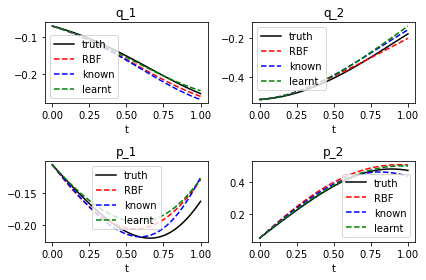

In [15]:
import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))
fig, axs = plt.subplots(2,2)
axs[0][0].plot(t,evaluate_known[4][:,0],label="truth", color="black")
axs[0][0].plot(t,evaluate_moi[1][:,0], "--", label="RBF", color="red")
axs[0][0].plot(t,evaluate_known[1][:,0], "--", label="known", color="blue")
axs[0][0].plot(t,evaluate_learnt[1][:,0], "--", label="learnt", color="green")
axs[0][0].set_title("q_1")
axs[0][0].set_xlabel("t")
axs[0][0].legend()

axs[0][1].plot(t,evaluate_known[4][:,1],label="truth", color="black")
axs[0][1].plot(t,evaluate_moi[1][:,1], "--", label="RBF", color="red")
axs[0][1].plot(t,evaluate_known[1][:,1], "--", label="known", color="blue")
axs[0][1].plot(t,evaluate_learnt[1][:,1], "--", label="learnt", color="green")
axs[0][1].set_title("q_2")
axs[0][1].set_xlabel("t")
axs[0][1].legend()

axs[1][0].plot(t,evaluate_known[4][:,2],label="truth", color="black")
axs[1][0].plot(t,evaluate_moi[1][:,2], "--", label="RBF", color="red")
axs[1][0].plot(t,evaluate_known[1][:,2], "--", label="known", color="blue")
axs[1][0].plot(t,evaluate_learnt[1][:,2], "--", label="learnt", color="green")
axs[1][0].set_title("p_1")
axs[1][0].set_xlabel("t")
axs[1][0].legend()

axs[1][1].plot(t,evaluate_known[4][:,3],label="truth", color="black")
axs[1][1].plot(t,evaluate_moi[1][:,3], "--", label="RBF", color="red")
axs[1][1].plot(t,evaluate_known[1][:,3], "--", label="known", color="blue")
axs[1][1].plot(t,evaluate_learnt[1][:,3], "--", label="learnt", color="green")
axs[1][1].set_title("p_2")
axs[1][1].set_xlabel("t")
axs[1][1].legend()

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.tight_layout()
#plt.savefig("figures/double_pendulum_predicted.pdf")


Text(0, 0.5, 'E')

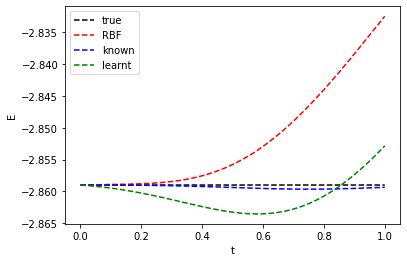

In [16]:
fig, ax = plt.subplots()
plt.plot(t, evaluate_learnt[5], "--",label="true", color="black")
plt.plot(t, evaluate_moi[6], "--",label="RBF", color="red")
plt.plot(t, evaluate_known[6], "--",label="known", color="blue")
plt.plot(t, evaluate_learnt[6], "--",label="learnt", color="green")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
#plt.savefig("figures/double_pendulum_energy.pdf")

In [ ]:

n_neighbours = 40


kernel = get_polynomial_local_invariance_2D(1.5, 6, 0, 0.5, n_neighbours, jitter, polynomial_degree) 
model_fixed = get_GPR_model_2D(kernel, mean, data, iterations=1000, old_model=known, fixed=True)

print(model_fixed.log_marginal_likelihood().numpy())


polynomial_degree = 3
print("learnt")
test_starting_position1 = np.radians(np.random.uniform(-max_x, max_x))
test_starting_position2 = np.radians(np.random.uniform(-max_x, max_x))
test_starting_velocity1 = np.radians(np.random.uniform(-max_v, max_v))
test_starting_velocity2 = np.radians(np.random.uniform(-max_v, max_v))
test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)

evaluate_moi = evaluate_model_future_2D(moi, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_moi[0])
evaluate_known = evaluate_model_future_2D(known, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_known[0])

evaluate_learnt_fixed = evaluate_model_future_2D(model_fixed, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_learnt_fixed[0])

evaluate_learnt_free = evaluate_model_future_2D(model, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_learnt_free[0])


grids_lml = []
grids_eva = []
for i in range(50):
    print(i)
    kernel_grid = get_polynomial_local_invariance_2D(1.5, 6, 0, 0.5, n_neighbours, jitter, polynomial_degree) 
    kernel_grid.poly = gpflow.Parameter(0.1*np.random.normal(size=kernel_grid.poly.shape), transform =tfp.bijectors.Sigmoid(to_default_float(-1.), to_default_float(1.)), trainable=False, prior=tfp.distributions.Laplace(to_default_float(0),(0.1)), name="poly")
    model_grid = get_GPR_model_2D(kernel_grid, mean, data, iterations=1000, old_model=known, fixed=True)
    print(model_grid.log_marginal_likelihood().numpy())

    evaluate_learnt_grid = evaluate_model_future_2D(model_grid, test_starting, dynamics, time_setting, scalers, energy)
    print(evaluate_learnt_grid[0])
    grids_eva.append(evaluate_learnt_grid[0])
    grids_lml.append(model_grid.log_marginal_likelihood().numpy())


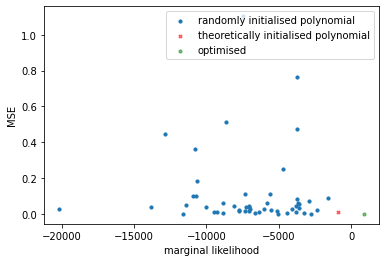

In [19]:

plt.scatter(grids_lml, grids_eva, s=10, label="randomly initialised polynomial")
plt.scatter(model_fixed.log_marginal_likelihood().numpy(), evaluate_learnt_fixed[0],marker="X",s=10, color="red", label="theoretically initialised polynomial", alpha=0.5)
plt.scatter(model.log_marginal_likelihood().numpy(), evaluate_learnt_free[0], s=10, color="green", label="optimised", alpha=0.5)
plt.xlabel("marginal likelihood")
plt.ylabel("MSE")
plt.legend()
plt.savefig("figures/double_pendulum_polynomial.pdf")

In [23]:

from scipy.stats import spearmanr, pearsonr
print(spearmanr(grids_lml, grids_eva))
print(pearsonr(grids_lml, grids_eva))

SpearmanrResult(correlation=-0.09493397358943578, pvalue=0.511959606175683)
(-0.02936637887763188, 0.8395703075825376)


In [26]:
min(grids_eva)

0.0006001384695890139